In [1]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from Bio import AlignIO
import random
import pickle
import h5py
import itertools
import dendropy
import numpy as np
import seaborn as sns
import os
import seaborn as sns
jk_iterations = 50
mapping = {'A':0 , 'T':1 , 'C':2 ,'G':3 }
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
#16s rna dataset from 'Detecting the Coevolution of Biosequences—An Example of RNA Interaction Prediction' 
import glob
#treefile = './16s/16s_wstruct.aln.fasta.treefile'
#alnfile = './16s/16s_wstruct.aln.fasta'

treefile = './16s/16s_salaminWstruct_aln.fasta.treefile'

alnfile = './16s/16s_salaminWstruct_aln.fasta'

events = './16s/16s_salaminWstruct_aln.fastasparsemat_AAtransitionbootstrap_runbootstrap_run_transition_*_coevmat.pkl'
eventmats = glob.glob(events)

In [3]:
print(eventmats)

[]


In [4]:
if os.path.exists(alnfile +'.h5'):
    with h5py.File(alnfile +'.h5', 'r') as hf:
        align_array = hf['MSA2array'][:]
print(align_array.shape)

(3783, 141)


In [5]:
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
treelen = tree.length()
treenodes = len(tree.nodes())
print('nodes',treenodes)
print('length',treelen)

nodes 282
length 49.026590402199986


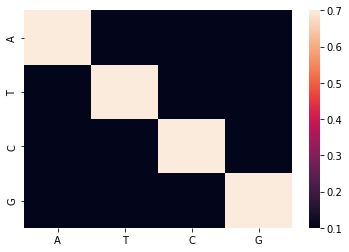

[[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]


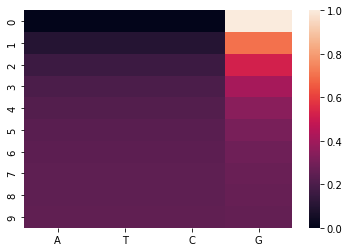

In [6]:
#toy jukes cantor model
state0 = np.array([0,0,0,1])
r = .1
jk = r*np.ones((4,4))
np.fill_diagonal(jk,0)
for i in range(jk.shape[0]):
    jk[i,i] = 1-np.sum(jk[i,:])

sns.heatmap(jk , xticklabels= mapping.keys( ), yticklabels= mapping.keys( ))
plt.show()
probas = []
for i in range(10):
    probas.append(state0)
    state0 = np.matmul(state0,jk)
sns.heatmap(np.vstack(probas),xticklabels= mapping.keys( ))

print(jk)

[[0.7 0.1 0.1 0.1]
 [0.1 0.7 0.1 0.1]
 [0.1 0.1 0.7 0.1]
 [0.1 0.1 0.1 0.7]]
[[ 0.35667494 -0.11889165 -0.11889165 -0.11889165]
 [-0.11889165  0.35667494 -0.11889165 -0.11889165]
 [-0.11889165 -0.11889165  0.35667494 -0.11889165]
 [-0.11889165 -0.11889165 -0.11889165  0.35667494]]


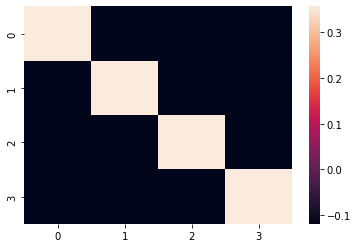

In [7]:
#define toy continuous jk model
print(jk)
jump_mat = copy.deepcopy(jk)
#define diag as exponential process
Qmat = np.zeros(jump_mat.shape)
#exponential
diag = []
for i in range(jump_mat.shape[0]):
    Qmat[i,i] = -np.log(jump_mat[i,i])
for i in range(jump_mat.shape[0]):
    for j in range(jump_mat.shape[1]):
        if i != j:
            Qmat[i,j] = -Qmat[i,i]*jump_mat[i,j]/(np.sum( jump_mat[i,:] )-jump_mat[i,i] ) 
print(Qmat)
sns.heatmap(Qmat)

plt.show()
w, v = LA.eig(Qmat)
v_inv = LA.inv(v) 


In [8]:
state0 = np.array([0,0,0,1])
probas = []
dt=.10
print(v.shape)
D = np.zeros((v.shape))

np.fill_diagonal(D,w)

print(w)

probas.append(state0)
print(Pdt)
t= 0
for i in range(20):
    t+=dt
    probas.append( np.matmul( state0 ,  Pt( Qmat ,dt )  ) )

sns.heatmap(np.vstack(probas),xticklabels= mapping.keys( ))

(4, 4)
[ 4.75566592e-01 -4.16333634e-17  4.75566592e-01  4.75566592e-01]


NameError: name 'Pdt' is not defined

In [ ]:
#align Ids

In [ ]:

transitionmat = np.zeros( (4,4))

#the number of actual events recorded should be number of transitions recorded / jk_iterations
coevmats_raw = {}

for outsankof in eventmats:
    print(outsankof)
    transition_type = outsankof.replace('./16s/16s_salaminWstruct_aln.fastasparsemat_AAtransitionbootstrap_runbootstrap_run_transition_'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    
    print(np.sum(coevmat))
    row = mapping[ transition_type[0] ]
    col = mapping[ transition_type[1] ]
    transitionmat[row,col] = coevmat.sum()
    transitionmat[row,col]/= jk_iterations
    coevmat/=jk_iterations
    coevmats_raw[transition_type] = coevmat.todense()

sns.heatmap(transitionmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())  

In [ ]:
transitionmat/=align_array.shape[1]*treelen
for i in range(transitionmat.shape[1]):
    transitionmat[i,i] = 1- np.sum(transitionmat[:,i])
    #markov transition mat

print(transitionmat)
sns.heatmap(transitionmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())

In [ ]:
#the state changes over all branches 
#eig(transition_mat) to get p(t) = c ( exp(eig) ) c^-1
from numpy import linalg as LA
w, v = LA.eig(transitionmat)

print(w)
print(v)

In [ ]:
v_inv = LA.inv(v)
print(v_inv)

In [ ]:
#eigenval  mat with time = 1
Q = np.array([ [ np.exp( w[i] ) if i==j else 0 for j in range(transitionmat.shape[1]) ] for i in range( transitionmat.shape[1])] ) 
print( Q )
#p(t) = v * Q^t * v_inv

In [ ]:
#get edge length distribution
edgelengths = []
for node in tree.nodes():
    if node.edge_length:
        edgelengths.append(node.edge_length)
plt.hist(edgelengths,15)
plt.show()
time_counts,time_bins = np.histogram( edgelengths , bins= 15 ) 

print(time_bins)
print(time_counts)

In [ ]:
tensor = []
coevmats_raw = {}
thresh_mats = .4
for i,outsankof in enumerate(eventmats):
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    coevmat = coevmat.todense()
    coevmat/= jk_iterations 
    if i == 0:
        globalmat_thresh = coevmat
        globalmat_thresh[thresh_mats > globalmat_thresh ] = 0        
    else:
        coevmat[thresh_mats > coevmat] = 0
        globalmat_thresh+= coevmat


for i,outsankof in enumerate(eventmats):
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    tensor.append( coevmat )
    coevmat = coevmat.todense()
    coevmat/= jk_iterations 
    if i == 0:
        globalmat = coevmat
    else:
        globalmat+= coevmat
    
    transition_type = outsankof.replace('./16s/16s_salaminWstruct_aln.fastasparsemat_AAtransitionbootstrap_runbootstrap_run_transition_'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    coevmats_raw[transition_type] = coevmat
    
    
    plt.hist( coevmat[coevmat>0].flat , bins = 40 )
    plt.show()
    plt.figure(figsize=(20,10))
    plt.spy(coevmat, markersize= .5)
    plt.title(outsankof)
    plt.show()
plt.figure(figsize=(20,10))
plt.title('all mutations')
plt.spy(globalmat,markersize= .5)
plt.show()

bigstack = np.vstack(tensor)

In [ ]:
#use tree to blur eventmat
from Bio import AlignIO
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
col = 525
aln_col = align_array[:,col]
def clipID(ID):
    return ID.replace('/',' ')

msa = AlignIO.read(alnfile , format = 'fasta')    
IDs = {i:clipID(rec.id) for i,rec in enumerate(msa)}
#IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
matsize = len(tree.nodes())
#add chars to leaves
for i,l in enumerate(tree.leaf_nodes()):
    if l.taxon.label in IDindex:
        l.taxon.label += ' '+ aln_col[IDindex[l.taxon.label]].decode()

#add events
for i,n in enumerate(tree.nodes()):
    if globalmat[i,col]>0:
        n.label = str( globalmat[i,col] )
    else:
        n.label = ''
#vis w event proba 
tree.print_plot( show_internal_node_labels = True , width = 100)

In [ ]:
for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None

matsize = len(tree.nodes())
print(matsize)
print('nodes')

#blur w connectivity mat
blurfactor =  .25
bluriter = 2

connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
lengths = np.array([ c.edge_length for n in tree.nodes() for c in n.child_nodes()])
total_len = np.sum(lengths)
#fill diagonal
#index = np.vstack( [index , np.array([ [n.matrow, n.matrow ] for n in tree.nodes() ]) ] )

connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1
connectmat = connectmat.todense()
np.fill_diagonal(connectmat , 1)

plt.figure( figsize=(10,10))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [ ]:
#blur the eventmats and find distribution of blurred jackknife

#use rbm ising model to capture features

vectors = []

#include the scaling factor and distribution params
jkparetto_transitions_vs_timebins = {}
jkparetto ={}
coevmats = {}

#get pareto distribution of jackknife by event type and time
for i,outsankof in enumerate(eventmats):
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    
    
 
    coevmat = coevmat.todense()
    for k in range( bluriter):
        print(np.sum(coevmat))
        coevmat += np.dot(blurfactor*connectmat, coevmat )
    print(np.sum(coevmat))

    if i == 0:
        globalmat_blur = coevmat
    else:
        globalmat_blur += coevmat
    
    transition_type = outsankof.replace('./16s/16s_wstruct.aln.fastasparsemat_AAtransitionbootstrap_runbootstrap_run_transition_'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    coevmats[transition_type] = coevmat
    print(np.sum(coevmat))
    '''coevmats[transition_type]=coevmat
    #generate a vector for each time bin
    previous_time = 0
    for t,max_time in enumerate(list(time_bins)):
        if max_time not in jkparetto_transitions_vs_timebins:
            jkparetto_transitions_vs_timebins[max_time] = {}
        #print('max time : ', max_time)
        node_inidices = [  node.matrow  for node in tree.nodes() if  node.edge_length and node.edge_length > previous_time and  node.edge_length >= max_time  ]
        #print('n branches : ', len(node_inidices))
        submat = coevmat[node_inidices , : ]
        previous_time = max_time
        submat = submat[submat>0].flatten()
        sum_events = np.sum(submat)
        submat /= sum_events
        
        #print('n events : ' , submat.shape)
        
        df, loc, scale = scipy.stats.genpareto.fit( submat.flat )
        
        #keep paretto parameters for this time bin and transition type
        jkparetto_transitions_vs_timebins[max_time][transition_type] = {'max_time':max_time, 'scaling': sum_events, 'df': df, 'loc':loc, 'scale':scale }
        x = np.linspace(scipy.stats.genpareto.ppf(.3, df, loc=loc , scale=scale ),
                scipy.stats.genpareto.ppf(.99, df  , loc=loc , scale=scale ), 100)
        if t < 3:
            plt.plot(x, scipy.stats.genpareto.pdf(x, df ,  loc=loc , scale=scale), '-', lw=2, alpha=0.6, label='pareto pdf ' + str(max_time))'''
    #plt.legend()
    #plt.show()
    vector =  coevmat[coevmat>0].flatten()
    vectors.append(vector)
    
    #vector =  coevmat.flatten()
    vector /= np.sum(vector)
    plt.hist( vector.flat , bins = 40 )
    df, loc, scale = scipy.stats.genpareto.fit( vector.flat )
    x = np.linspace(scipy.stats.genpareto.ppf(.4, df, loc=loc , scale=scale ),
                scipy.stats.genpareto.ppf(.999, df  , loc=loc , scale=scale ), 100)
    plt.plot(x, scipy.stats.genpareto.pdf(x, df ,  loc=loc , scale=scale), 'r-', lw=5, alpha=0.6, label='pareto pdf')
    plt.legend()
    
    plt.figure(figsize=(20,10))
    plt.spy(coevmat, markersize= .5)
    plt.title(outsankof)
    plt.show()


print('calculating pareto for total event scores')
vectors = np.hstack(vectors)
sum_events =  np.sum(vectors)
vectors /= np.sum(vectors)
plt.hist( vectors.flat , bins = 40 )

df, loc, scale = scipy.stats.genpareto.fit( vectors.flat )
x = np.linspace(scipy.stats.genpareto.ppf(.25, df, loc=loc , scale=scale ),
                scipy.stats.genpareto.ppf(.999, df  , loc=loc , scale=scale ), 100)

plt.plot(x, scipy.stats.genpareto.pdf(x, df ,  loc=loc , scale=scale), 'r-', lw=5, alpha=0.6, label='pareto pdf')
plt.legend()
plt.show()

jkpareto = { 'scaling': sum_events, 'df': df, 'loc':loc, 'scale':scale }

In [ ]:
#use tree to blur eventmat
from Bio import AlignIO
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
col = 521
aln_col = align_array[:,col]
def clipID(ID):
    return ID.replace('/',' ')

msa = AlignIO.read(alnfile , format = 'fasta')    
IDs = {i:clipID(rec.id) for i,rec in enumerate(msa)}
#IDs = {i:rec.id for i,rec in enumerate(msa)}
IDindex = dict(zip( IDs.values() , IDs.keys() ) )
matsize = len(tree.nodes())
#add chars to leaves
for i,l in enumerate(tree.leaf_nodes()):
    if l.taxon.label in IDindex:
        l.taxon.label += ' '+ aln_col[IDindex[l.taxon.label]].decode()

#add events
for mat in coevmats:
    print(mat)
    for i,n in enumerate( tree.nodes() ):
        if coevmats[mat][i,col] > 0:
            n.label = str( coevmats[mat][i,col] )
        else:
            n.label = ''
    #vis w event proba 
    tree.print_plot( show_internal_node_labels = True , width = 100)

In [ ]:
from functools import partial

#define the jack knife / blur score proba functions

def discretize(t, timebins):
    #return a discvretized time to call a bin of the hist of jackknife score
    prevtime = 0
    for time in timebins:
        if t > prevtime and t<= time:
            return time
    else:
        return max(timebins)

def p_jacknife(jacknife , pdf_jk):
    #given a jacknife score, what is its probability over all scores
    jacknife /=pdf_jk['scaling']
    
    return scipy.stats.genpareto.cdf(jacknife , pdf_jk['df']  , loc=pdf_jk['loc'] , scale= pdf_jk['scale'] )

def p_jacknife_given_s1s2t( jacknife, s1,s2, t , jk_pdfs  ):
    #given that a transition was detected over t, what is the probability of this jackknife/blur score
    #derive a distribution of jack_knife/blur score for each transition type and time
    #get the pvalue of a jackknife score sampling the normalized 2d hist ( distribution of scores over time bins )
    timebin = discretize(t)
    jacknife/=jk_pdfs[timebin][s1+s2]['scaling']
    return scipy.stats.genpareto.cdf(jacknife , jk_pdfs[timebin][s1+s2]['df']  , loc=jk_pdfs[timebin][s1+s2]['loc'] , scale= jk_pdfs[timebin][s1+s2]['scale'] )

p_jacknife = partial(p_jacknife,  pdf_jk = jkpareto  )
p_jacknife_given_s1s2t = partial(p_jacknife_given_s1s2t,  jk_pdfs = jkparetto_transitions_vs_timebins )
discretize = partial(discretize , timebins = list(time_bins)  )

In [ ]:
def p( t , v, v_inv, w):
    #define transition probability given two states and time elapsed using mutation rates for markov process
    Q = np.array([ [ np.exp( w[i]*t ) if i==j else 0 for j in range(w.shape[0]) ] for i in range( w.shape[0])] ) 
    probas_over_t = v * Q * v_inv
    return probas_over_t

def p_dual( t , v, v_inv, w):
    #define transition probability given two states and time elapsed using mutation rates for markov process
    Q = np.array([ [ np.exp( w[i]*t ) if i==j else 0 for j in range(w.shape[0]) ] for i in range( w.shape[0] ) ] )
    probas_over_t = v*Q*v_inv
    return probas_over_t

def bayes_jk( s1,s2, t , jacknife ):
    #give the score of this transition, what is the proba it occured here
    #depends on blurred jackknife distribution and markov transition proba
    #sum jacknife prob, transition mat colum and p jackknife all = 1
    
    conditioning = p_jacknife_given_s1s2t(jacknife, s1,s2, t ) / p_jacknife(jacknife)
    return conditioning


In [ ]:
######important 
mapping = {'A':0 , 'T':1 , 'C':2 ,'G':3 }
transitions = [ char1+char2  for char1 in mapping.keys() for char2 in mapping.keys()]
transitionmap = { t:i for i,t in enumerate(transitions) }
print(transitionmap)
print(mapping)

In [ ]:
def make_ancestral_states(tree, cols):
    #use the aln and tree w no jacknife to make a tree of ancestral states for one or two cols
    
    
def get_transitino_mat_p(node, mapping , codons =False , verbose = True):
    #parse tree and aln and find the number of transitions to derive transition mat using coevmat
    
    #this should work for a tree instantiatiated w one or two codons or one or two columns ( 6,3 or 2,1 columns )

    
    

def process_node_smallpars_1(node):
    #go from leaves up and generate character sets
    if node.symbols is None:
        for child in node.child_nodes():
            if child.symbols is None:
                process_node_smallpars_1(child)
        node.symbols = { }
        node.scores = { }
        for pos in range(len(child.symbols)):
            symbols = set.intersection( * [ child.symbols[pos] for child in node.child_nodes( ) ] )
            if len(symbols) == 0:
                symbols = set.union( * [ child.symbols[pos] for child in node.child_nodes( ) ] )
            node.symbols[pos] = symbols
            node.scores[pos] = { }
            for c in allowed_symbols:
                if c not in node.symbols[pos]:
                    #add trnasition mat here if needed
                    score = min(  [ child.scores[pos][c] for child in node.child_nodes()])+1
                else:
                    score = min(  [ child.scores[pos][c] for child in node.child_nodes() ] )
                node.scores[pos][c] = score

def process_node_smallpars_2(node , eventmat , codons = False, verbose = False):
    #assign the most parsimonious char from children
    if node.char is None:
        if node.parent_node:
            #node has parent
            node.char = {}
            node.event = {}
            node.eventype= {}
            node.AAevent = 0
            for pos in range(len(child.symbols)):
                node.char[pos] = min(node.scores[pos], key=node.scores[pos].get)
                if node.parent_node.char[pos] == node.char[pos]:
                    node.event[pos] = 0
                else:
                    if node.scores[pos][node.parent_node.char[pos]] == node.scores[pos][node.char[pos]] :
                        node.char[pos] = node.parent_node.char[pos]
                        node.event[pos] = 0
                    else:
                        node.event[pos] = 1
                        node.eventype[pos] = transition_dict[node.parent_node.char[pos]+node.char[pos]]
            ##### change this for the possibility of tracking two codons at once
            if codons == True:
                node.AA = str(Seq.Seq(b''.join([ node.char[pos] for pos in [0,1,2] ]).decode() ).translate())
                if node.AA != node.parent_node.AA and nucleotides_only == False:
                    node.AAevent = transitiondict_AA[node.parent_node.AA+node.AA]
                    if verbose == True:
                        print( node.parent_node.AA , ' -> ' ,  node.AA)
        else:
            #root node
            node.char = {}
            node.event= {}
            node.eventype = {}
            node.AAevent = 0
            for pos in [0,1,2]:
                node.char[pos] = min(node.scores[pos], key=node.scores[pos].get)
                node.event[pos] = 0
            if codons == True:
                node.AA = Seq.Seq(b''.join([ node.char[pos] for pos in [0,1,2] ]).decode() ).translate()
            else:
                node.AA = 'G'
        #down one level
        for child in node.child_nodes():
            if child.char is None:
                process_node_smallpars_2(child)

def calculate_small_parsimony( t, aln_columns , row_index , verbose  = False ):
    missing = 0
    #assign leaf values
    for pos,col in enumerate(aln_columns):
        for l in t.leaf_nodes():
            if hasattr(col , 'decode'):
                #column has no events
                l.calc[pos] = False
                char = col
                l.event[pos] = 0
                l.scores[pos] = { c:10**10 for c in allowed_symbols }
                if char.upper() in allowed_symbols:
                    l.symbols[pos] = { char }
                    l.scores[pos][char] = 0
                else:
                    #ambiguous leaf
                    l.symbols[pos] = allowed_symbols
            else:
                #setup for small_pars1
                l.calc[pos] = True
                l.event[pos] =0
                l.scores[pos] = { c:10**10 for c in allowed_symbols }

                if str(l.taxon).replace("'", '') in row_index:

                    char = col[ row_index[str(l.taxon).replace("'", '')]  ]
                    if char.upper() in allowed_symbols:
                        l.symbols[pos] = { char }
                        l.scores[pos][char] = 0
                    else:
                        #ambiguous leaf
                        l.symbols[pos] =  allowed_symbols
                else:
                    missing += 1
                    char = None
                    l.symbols[pos] =  allowed_symbols
                    if verbose == True:
                        print( 'err ! alncol: ', l.taxon , aln_column  )
                l.char[pos] = min(l.scores[pos], key=l.scores[pos].get)
    #up
    process_node_smallpars_1(t.seed_node)
    #down
    
    #generate the eventmat
    process_node_smallpars_2(t.seed_node ,eventmat)
    eventdict = {}
    for pos in [0,1,2]:
        eventindex = [ n.matrow for n in t.nodes() if n.event[pos] > 0 ]
        eventtypes = [ n.eventype[pos] for n in t.nodes() if n.event[pos] > 0 ]
        eventdict[pos] = { 'type': eventtypes , 'index' : eventindex }
    AAeventindex = [ n.matrow for n in t.nodes() if n.AAevent > 0 ]
    AAeventypes = [ transition_dictAA[n.AAevent] for n in t.nodes() if n.AAevent > 0 ]
    if verbose == True:
        with iolock:
            print('smallpars done')
            print(eventdict)
            print(AAeventindex)
    return (eventdict , AAeventindex , AAeventypes)

In [ ]:
#use two colums to derive the dual model
def doublemat_Pdt(coevmats ,  col1 , col2 , verbose = True ):
    jump_mat = copy.deepcopy(transitionmat)
    Qmat = np.zeros(jump_mat.shape)
    #exponential
    for i in range(jump_mat.shape[0]):
        Qmat[i,i] = -np.log(jump_mat[i,i])
    for i in range(jump_mat.shape[0]):
        for j in range(jump_mat.shape[1]):
            if i != j:
                Qmat[i,j] = -Qmat[i,i]*jump_mat[i,j]/(np.sum( jump_mat[i,:] )-jump_mat[i,i] )
    w, v = LA.eig(Qmat)
    v_inv = LA.inv(v)  
    if verbose == True:
        return v,v_inv, w ,transitionmat
    else:
        return v,v_inv, w 

#return the Pmat over a give edge len
def p( edge_length, v, v_inv, w):
    return v_inv * np.exp(edge_length*w) * v

In [ ]:
col = 119
#markov transition mat for 1 col
v, vinv , w , transitionmat , Qmat  = singlemat_Pdt( coevmats_raw , col , verbose = True)
print(w)
sns.heatmap(transitionmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())
plt.show()
print(Qmat)
sns.heatmap(Qmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())
plt.show()

In [ ]:
col1 = 119 
col2 = 120

#markov transition mat for 2 cols
v, vinv , w , transitionmat = doublemat_Pdt(coevmats_raw ,  col1 , col2 )
sns.heatmap(transitionmat,  xticklabels=transitionmap.keys() , yticklabels=transitionmap.keys())

print(w)
print( np.sum(transitionmat, axis = 1))

print( np.sum(transitionmat, axis = 0))

plt.show()
Qmat = treelen*transitionmat
np.fill_diagonal(Qmat,0)
for i in range(Qmat.shape[0]):
    Qmat[i,i] = -np.sum(Qmat[i,:])
sns.heatmap(Qmat, xticklabels= transitionmap.keys( ) , yticklabels=transitionmap.keys())
plt.show()

In [ ]:
print( align_array[:, col2])

In [ ]:
#find the probability of a transition tree
#proba over each branch of the transition or no change for all internal states
#use priors derived from jackknife and blur and sankoff do not explore all possibilities
def get_levels_p(node , coevmats , P , col , verbose = True):
    #using the felstein pruning algo calculate the proba only the relevant tree levels
    #go from leaves up
    if node.L is None:
        for child in node.child_nodes():
            if child.L is None:
                get_levels_p(child , coevmats,P,col )
        v,v_inv, w = P
        #calculate the conditional proba as a function of all states possible in each child node and parent
        node.L={}
        for s in mapping:
            node.L[s]=1
        
        for child in node.child_nodes():
            L={}
            for s in mapping:
                L[s]=0
            #find transition probas for branch len
            Pmat = p( child.edge_length, v, v_inv, w)
            
            for s1 in mapping:
                #get the max likelihood here for every state
                for s2 in mapping:
                    if s1+s2 in coevmats:
                        if coevmats[s1+s2][child.matrow,col] > 0 :
                            #there may have been a change here.
                            L[s1] += Pmat[mapping[s1],mapping[s2]] * bayes_jk( s1,s2, child.edge_length , coevmats[s1+s2][child.matrow,col] ) * child.L[s2]
                            print( bayes_jk( s1,s2, child.edge_length , coevmats[s1+s2][child.matrow,col] ))
                    else:
                        #no change
                        if Pmat[mapping[s1],mapping[s2]] > 0:
                            L[s1] += Pmat[mapping[s1],mapping[s2]] * child.L[s2]
                            
                        else:
                            L[s1] += child.L[s2] * 10**-6 
        #could be an error here due to alnchar:
            
            for s in mapping:
                node.L[s] *= L[s]
            
        if sum(node.L.values()) ==0:
            print(Pmat)
            for child in node.child_nodes():
                print(child.taxon)
                print(child.L)


        
        node.Ltotal = sum(node.L.values())
        if verbose == True:
            print( 'L', L)
        if verbose == True:
            print(node.L)

def get_levels_p_dual(node , coevmats , P , col1  , col2 ):
    #using the felstein pruning algo calculate the proba only the relevant tree levels
    #go from leaves up
    if node.L1 is None:
        for child in node.child_nodes():
            if child.L1 is None:
                get_levels_p_dual(node , coevmats , P , col1  , col2 )
        v,v_inv, w = P
        #calculate the conditional proba as a function of all states possible in each child node and parent        
        for child in node.child_nodes():
            if child.L is None:
                get_levels_p(child , coevmats,P,col )
        v,v_inv, w = P
        #calculate the conditional proba as a function of all states possible in each child node and parent
        node.L1={}
        node.L2={}
        for s in mapping:
            node.L[s]=1
        for child in node.child_nodes():
            L={}
            for s in mapping:
                L[s]=0
            
            #find transition probas for branch len
            Pmat = p( child.edge_length, v, v_inv, w)
            for t1 in transitionmap:
                #get the max likelihood here for every state
                for t2 in transitionmap:
                    s1_1 = t1[0]
                    s1_2 = t1[1]
                    s2_1 = t2[0]
                    s2_2 = t2[1]        
                    p = Pmat[transitionmap[t1],transitionmap[t2]] * child.L[s1_2]   
                    for t in [t1, t2]:
                        if t in coevmats:
                            p *= bayes_jk( s2_1,s2_2  , child.edge_length , coevmats[t2][child.matrow,col] )
                    L1[s1_1] += p
                
                node.L1[s1_1]*= L[s1_1]
                node.L2[s2_1]*= L[s2_1]

def L_single(tree , coevmats , P , col , alncol , verbose = True ):
    
    if verbose == True:
        print('calc p for single site')
    #assign the states to leaves
    for i,n in enumerate(tree.nodes()):
        n.matrow = i
        n.L = None
    for l in tree.leaf_nodes():
        #leaf in aln
        l.L= {}
        if l.taxon.label in IDindex:
            if alncol[IDindex[l.taxon.label]].decode() in mapping:
            #set state to aln char
                l.char = alncol[IDindex[l.taxon.label]].decode()
                for c in mapping:
                    l.L[c] = 0
                l.L[l.char] = 1
            elif alncol[IDindex[l.taxon.label]].decode() == '-':
                for c in mapping:
                    l.L[c] = 1/len(mapping)
            else:
                l.char = None
                for c in mapping:
                    l.L[c] = 1/len(mapping)
        else:
            l.char = None
            for c in mapping:
                l.L[c] = 1/len(mapping)
        
    L = get_levels_p(tree.seed_node, coevmats , P , col )

def L_double(tree , coevmats , P , col1, col2 , alncol1, alncol2 , verbose = True ):
    
    if verbose == True:
        print('calc p for single site')
        
    #assign the states to leaves
    for i,n in enumerate(tree.nodes()):
        n.matrow = i
        n.L = None
    for l in tree.leaf_nodes():
        #leaf in aln
        l.L1= {}
        l.L2= {}
        for alncol,L in [ (alncol1,l.L1) , (alncol2 , l.L2)]:
            if l.taxon.label in IDindex:
                if alncol[IDindex[l.taxon.label]].decode() in mapping:
                #set state to aln char
                    l.char = alncol[IDindex[l.taxon.label]].decode()
                    for c in mapping:
                        L[c] = 0
                    L[l.char] = 1
                elif alncol[IDindex[l.taxon.label]].decode() == '-':
                    for c in mapping:
                        L[c] = 1/len(mapping)
                else:
                    l.char = None
                    for c in mapping:
                        L[c] = 1/len(mapping)
            else:
                l.char = None
                for c in mapping:
                    L[c] = 1/len(mapping)
    L = get_levels_p_dual(tree.seed_node, coevmats , P , col )
    


In [ ]:
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
P  = singlemat_Pdt( coevmats_raw , col1 , verbose = False)
L_single(tree , coevmats , P , col1 , align_array[:, col1], verbose = True)

In [ ]:
for outsankof in eventmats:

    transition_type = outsankof.replace('./16s/16s_salaminWstruct_aln.fastasparsemat_AAtransitionbootstrap_runbootstrap_run_transition_'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    coevmat = coevmat.todense()
    
    sumv = np.sum(coevmat , axis = 0)
    cdf = np.array( np.cumsum(sumv) / np.sum(sumv))
    plt.plot( cdf[0] , label= transition_type  )
    
cdf_uniform = np.cumsum(np.ones(len(cdf.ravel())) ) / np.sum(len(cdf.ravel()))

plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')
plt.legend()
plt.title( 'spatial distribution of mutation events in 16sRNA' )
plt.show()

In [ ]:

#####define the aln row and structure here

print(IDindex['ga.Esc.col'])
print(align_array[0])
#filter to columns without gaps
msa_row = list(align_array[0])
print(len(msa_row))
non_gap = np.where( align_array[IDindex['ga.Esc.col']] != b'-')[0]
print(non_gap)

print(non_gap.shape)
print(align_array[IDindex['ga.Esc.col'],non_gap])

In [ ]:
from Bio.PDB import MMCIFParser
from Bio.PDB.mmcifio import MMCIFIO
parser = MMCIFParser()
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    structure = parser.get_structure("4v9d", "./16s/4v9d.cif")
io=MMCIFIO()
io.set_structure(structure)

In [ ]:
#grab RNA

totalatoms = { c.id : [ r for r in c.get_residues() if r.get_resname() in {'A', 'U' , 'C' , 'G'} ] for c in structure.get_chains() }


In [ ]:
#measure from phosphorus to phosphorus
distmats = {}
for chain in totalatoms:
    distmats[chain] = np.array( [[ a1['P'] - a2['P']  if (i<j and 'P' in a1 and 'P' in a2) else 0 for i,a1 in enumerate(totalatoms[chain])] for j,a2 in enumerate(totalatoms[chain]) ] )


In [ ]:
show_distmats = False

for chain in distmats:
    distmats[chain] += distmats[chain].T
if show_distmats == True:
    for i,chain in enumerate(distmats):
        if distmats[chain].shape[0]>0:
            plt.figure(figsize= (20,20))
            plt.title( 'distmat ' + chain )

            plt.imshow(distmats[chain])
            plt.colorbar()
            plt.show()


In [ ]:
import copy

subunit = distmats['BA']
print(subunit)
subthresh = copy.deepcopy(subunit)
subthresh[ subthresh < 25 ] = 1 
subthresh[ subthresh > 25 ] = 0 
np.fill_diagonal(subthresh , 0)
print(subthresh)

In [ ]:
from sklearn.manifold import Isomap , MDS , locally_linear_embedding
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans , DBSCAN ,SpectralClustering ,OPTICS , AgglomerativeClustering
import sklearn

In [ ]:
def return_clustering(codonmat, calc_isomap = False , scale = True , dbscan = False , xi = 0.035 , samples = 5 , jaccard = True , reductionfactor= .75):
    if scale == True:
        scaler = sklearn.preprocessing.RobustScaler( )
        codonmat = scaler.fit_transform(codonmat.T).T
    if calc_isomap == True:
        try:
            isomap = Isomap( n_neighbors= 25, n_components= int(codonmat.shape[0]*reductionfactor) , eigen_solver='auto', tol=0, 
               max_iter=None, path_method='auto', neighbors_algorithm='auto', n_jobs=-1 )
            #isomap = sklearn.manifold.locally_linear_embedding(n_neighbors=25, n_components=50)
            codonmat = isomap.fit_transform( X=codonmat.T ).T
        except:
            pass
    
    if jaccard == False:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            apb = OPTICS(min_samples=samples, metric='minkowski', p=1.5, metric_params=None, cluster_method='xi', eps=None, xi=xi, predecessor_correction=True, min_cluster_size=2 , algorithm='auto', leaf_size=20, n_jobs=-1)
            cluster_labels_codon = apb.fit_predict(codonmat.T )    
    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            apb = OPTICS(min_samples=samples, metric='jaccard', p=1.5, metric_params=None, cluster_method='xi', eps=None, xi=xi, predecessor_correction=True, min_cluster_size=2 , algorithm='auto', leaf_size=20, n_jobs=-1)
            cluster_labels_codon = apb.fit_predict(codonmat.T )
    
    return cluster_labels_codon

def subcluster( mat , cluster_thresh=10 , indices = None  ,  iter_thresh = 15 , clusterlevel = 'head' , clustiter =0, calc_isomap = False , scale = True , xi = .035 , samples = 5 , verbose = False , jaccard = False  ):
    #break a large cluster into smaller subclusters until avg cluster size is below thresh
    if verbose == True:
        print('clustering' , clusterlevel)
    
    cluster_labels = return_clustering(mat, calc_isomap=calc_isomap  , scale=scale  , dbscan=dbscan  ,xi = xi , samples = samples , jaccard = jaccard)
    
    if verbose == True:
        print('DONE clustering ', clusterlevel)
    if indices is None:
        indices = np.arange(mat.shape[1])
    
    l,c = np.unique(cluster_labels, return_counts= True)
    if len(l) == 1:
        xi += .01
        if verbose == True:
            print(l)
            print('xi',xi)
    if verbose == True:
        print('l',l)
        print('c',c)
    clustering = {  'labels': cluster_labels , 'sub':{} , 'mappings':{}  }
    #if we're over the max recursion
    kmeans = False
    if clustiter < iter_thresh:
        
        for i,label in enumerate(list(l)):
            clustering['mappings'][label] = indices[cluster_labels == label]
            if c[i] > cluster_thresh:
                if verbose == True:
                    print( 'reclustring',label , c[i] )
                    print( 'min samples' , samples )
                #isomap within clusters
                
                #don't split up clusters formed from columns with no events
                
                clustering['sub'][label] = subcluster( mat[:,cluster_labels==label] , cluster_thresh =cluster_thresh ,indices= clustering['mappings'][label] , iter_thresh = iter_thresh , clusterlevel= str(label)+'_'+str(clustiter), samples = samples,  clustiter = clustiter + 1 , calc_isomap = True , jaccard = False ,  xi= xi , scale = scale  )
                samples = max( 2 , samples-1 )
    return clustering

In [ ]:
def return_sub(indict, level= 0 ,mapping = None):
    l,c = np.unique(indict['labels'] , return_counts= True)
    for clust in list(l):
        if 'sub' not in indict or clust not in indict['sub']:
            if clust != -1:
                yield indict['mappings'][clust]  
        else:
            return_sub( indict['sub'][clust], level = level +1 )
        

In [ ]:
from sklearn.covariance import GraphicalLassoCV , ShrunkCovariance , EmpiricalCovariance

def divide_clusters( subclustering_dict , cols ):
    #only go down one level for now
    cluster_dict={}
    count =0
    total_labels = np.ones((cols,))*-1
    for mapping in return_sub(subclustering_dict):
        total_labels[mapping] = count
        count += 1
    return total_labels
    #setup sublcluster dictionary

def clusters2pairs( cluster_labels , mat , use_outliers =True,  verbose = True ):
    #subcluster further using sparse inv cov within clusters to form pairs
    count = 0
    l,c = np.unique(cluster_labels, return_counts= True)
    print(l)
    print(c)
    print(mat.shape)
    pairs = []
    for label in l:
        print(label)
        if label != -1 or use_outliers == True:
            submat = mat[:, cluster_labels == int(label)]
            
            print(submat.shape)

            #edge_model = GraphicalLassoCV(mode ='lars',max_iter = 1000)
            #edge_model = EmpiricalCovariance()
            #edge_model = ShrunkCovariance()
            
            submat /= submat.std(axis=0)
            
            edge_model.fit(submat)
            partial_correlations = edge_model.precision_.copy()
            
            if verbose == True:
                
                plt.imshow(edge_model.covariance_)
                plt.colorbar()
                plt.show()

                plt.imshow(partial_correlations)
                plt.colorbar()
                plt.show()
            print(partial_correlations)
            d = 1 / np.sqrt(np.diag(partial_correlations))
            partial_correlations *= d
            partial_correlations *= d[:, np.newaxis]
                
            non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)
            if verbose == True:
                print(non_zero)
            #extract pairs

In [ ]:
def check_point(contactsx , contactsy, ptx,pty, radius = 10 , verbose = False):
    #find non zero contact pts
    for center_x, center_y, in zip(contactsx,contactsy):
        if (ptx - center_x)**2 + (pty - center_y)**2 < radius**2:
            if verbose == True:
                print(ptx,pty,center_x, center_y)
                print('left', (ptx - center_x)**2 + (pty - center_y)**2 )
                print( 'right', radius**2 )
                
            return True
    return False


In [ ]:
import scipy
#
contactsx , contactsy  = (np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1])

#multiply connectivity mat to get 1 degree of separation 

connected = np.dot(subthresh,subthresh)
connnectedx , connectedy  = (np.nonzero(connected)[0] ,np.nonzero(connected)[1])
blurfactor =  .25

plt.figure(figsize=(10,10) )
plt.title('contact mat')
plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .002525,  s = 50)
plt.show()

plt.figure(figsize=(10,10) )
plt.title('contact 1 degree of sep')
plt.scatter(connnectedx ,connectedy  , marker= 'o' , alpha = .002525,  s = 50)
plt.show()

In [ ]:
#calculate clusters by distance thresholding
#looks like a mess....

bluriters = [100]

for bluriter in bluriters:
    #bluriter
    #do all vs all 
        #blur w connectivity mat
    coevmat = copy.deepcopy(globalmat)
    
    for k in range( bluriter):
        print('blurring x' , k)
        coevmat += np.dot(blurfactor*connectmat, coevmat )
    greens = []
    reds=[]
    oranges=[]
    dist = scipy.spatial.distance.pdist(coevmat.T)
    print(dist.shape)
    
    plt.hist(dist)
    plt.show()
    hist,edges = np.histogram( dist , bins=10)
    print(edges)
    
    plt.figure(figsize=(10,10) )

    dist =  scipy.spatial.distance.squareform(dist)
    sns.heatmap(dist)
    plt.show()
    
    
    for thresh in list(edges)[:-1]:
        
        print(thresh)
        threshmat = copy.deepcopy(dist)
        threshmat[dist>thresh] = 0
        threshmat[dist <= thresh] = 1
        threshmat = threshmat[non_gap,:]
        threshmat = threshmat[:,non_gap]
        np.fill_diagonal(threshmat, 0)
        
        print('infered interactors ' , np.sum(threshmat) / 2 )
        sns.heatmap(threshmat)
        plt.title('thresh:'+str(thresh))
        plt.show()
               
        #check for contact pts
        ptsx,ptsy = np.nonzero( threshmat )
        print(len(ptsx))
        print(len(ptsy))
        
        ptsx = list(ptsx)
        ptsy = list(ptsy)
        pts =  list( zip(ptsx,ptsy) )
        green = [ 1 if  ptx > pty and  ptx < threshmat.shape[0] and pty < threshmat.shape[1] and check_point(list(contactsx) , list(contactsy), ptx,pty, radius = 10 , verbose = False) else 0 for ptx,pty in pts ]
        #check for connected components
        print('green pts' ,np.sum(green))
        
        orange = [ 1 if  ptx > pty and  ptx < threshmat.shape[0] and pty < threshmat.shape[1] and check_point(list(connnectedx) , list(connectedy) ,ptx,pty, radius = 5 , verbose = False) else 0 for ptx,pty in pts  ]
        print('oragne pts ' , np.sum(orange))

        #all detected points not in orange and green
        red = np.array(green) + np.array(orange)
        red[red > 0 ] = 1
        red = np.abs(1 - red )
        print('red pts ' , np.sum(orange))
        
        
        greens.append(np.sum(green))
        oranges.append(np.sum(orange))
        reds.append(np.sum(red))
    print(greens)
    print(oranges)
    print(reds)
    plt.plot(greens,c='green')
    plt.plot(reds,c='red')
    plt.plot(oranges,c='orange')
    plt.title('bluriter '+str(bluriter) )
    plt.show()

In [ ]:
print(cluster_labels)
l,c = np.unique(non_gap_labels, return_counts= True)
print(l)
print(c)
mat = copy.deepcopy(globalmat[:,non_gap])
plt.hist(np.sum(mat , axis= 0 ).flat , bins = 50)
plt.show()
for label in list(l):
    print(label)
    plt.hist( np.sum(mat[:,cluster_labels == label] , axis = 0 ).flat , density = True)
    plt.show()

In [ ]:
#calculate clustering using recursive optics and isomap
verbose = True
show_intra_clust_dist = True
show_hits = True 
show_mat = True

import itertools
from scipy.stats import gumbel_l


connected = np.dot(subthresh,subthresh)
connnectedx , connectedy  = (np.nonzero(connected)[0] ,np.nonzero(connected)[1])

globalmat_blur_thresh = copy.deepcopy(globalmat_blur)
globalmat_blur_thresh[ globalmat_blur_thresh < 20 ] = 0

#for blur iter in blur
#count the number of green / orange / red

maxiter = 20
blurs = []
increment = 100
blurs = 0
blurvec =[0]
lastreds = 100
totalreds = [0]
totalgreens = [0]
totaloranges = [0]
shuffle_iter = 1000
#find within cluster eval for a pair 
import random

In [ ]:
for bluriteration in [100,110,120,130,140,150 ]:
    mat = copy.deepcopy(globalmat)
    for k in range(int( bluriteration ) ):
        mat += np.dot(blurfactor*connectmat, mat )
    print('blurs',bluriteration ) 
    
    print(mat.shape)
    submat = mat[:,non_gap]
    print(submat.shape)
    
    print('recursive clustering')
    cluster_labels = divide_clusters( subcluster( submat, calc_isomap= True , jaccard = False,  scale = False )  , submat.shape[1])
    print('done')
    
    #add the uinformative columns to -1
    cluster_labels[ np.sum(submat , axis = 0 ).flat == 0 ] = -1
    non_gap_labels = cluster_labels[:,non_gap]
    
    l,c = np.unique(cluster_labels, return_counts= True)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for k in range(len(l))   ]

    print('labels' , l )
    print('counts' , c )
    
    if show_intra_clust_dist == True:
        for i,label in enumerate(list(l.flat)):
            if i < 10:
                if c[i]< 20 and c[i]>2:
                    print('intracluster dists: ' , label)
                    
                    zeroed = np.where(cluster_labels == label )[0]
                    print(zeroed)

                    combos =  [ c for c in itertools.combinations(list(zeroed) , 2)]                        
                    
                    if verbose == True:
                        
                        plt.figure(figsize=(30,10))
                        plt.imshow(submat[:,zeroed])
                        plt.show()
                        
                        plt.figure(figsize=(30,10))
                        plt.spy(submat[:,zeroed])    
                        plt.show()
                    
                    
                    if len(combos)>3:
                        print(combos)
                        scrambled = []
                        distances = []
                        shuffleiter = 100
                        for combo in combos:
                            #find intracluster distances 
                            c1 = copy.deepcopy(submat[:,combo[0]])
                            c2 = copy.deepcopy(submat[:,combo[1]])
                            dist = scipy.spatial.distance.euclidean(c1, c2 )
                            c1_scramble = copy.deepcopy(submat[:,combo[0]])
                            c2_scramble = copy.deepcopy(submat[:,combo[1]])
                            distances.append( dist )
                            for shuffle in range(shuffleiter):
                                np.random.shuffle(c1_scramble)
                                np.random.shuffle(c2_scramble)
                                dist = scipy.spatial.distance.euclidean(c1_scramble, c2_scramble  )
                                scrambled.append( dist )
                        #fit gumbel

                        #cutoff w p val
                        
                            
                        scrambled = np.array(scrambled)
                        distances = np.array(distances)
                        
                        #add pval cutoff
                        plt.hist(scrambled , label = 'scrambled' , alpha = .5, density=True)
                        plt.hist(distances, label = 'coev' ,  alpha = .5, density=True)
                        plt.legend()
                        plt.title('cluster'+str(label))
                        plt.show()

    
    
    if show_mat == True:
        plt.figure(figsize=(45,100))
        for i,label in enumerate(list(l.flat)):
            mask = copy.deepcopy(globalmat)
            mask = mask[:,non_gap]
            mask[:, label!=cluster_labels ] =0
            plt.spy(mask, markersize= .5 ,c=color[i] )
        plt.show()
                        
    if show_hits == True:
        plt.figure(figsize=(20,20) )
        for i,label in enumerate(list(l.flat)):
            if c[i]< 15 and c[i]>2 : 
                zeroed = np.where(non_gap_labels == label )[0]
                if len(list(zeroed))>2:
                    combos = list(zip( * [ c for c in itertools.combinations(list(zeroed) , 2)]))
                    
                    
                    try:
                        plt.scatter( combos[0] , combos[1] , c= color[i] , marker= 'X', s=100)
                        plt.scatter( combos[1], combos[0] , c= color[i] , marker= 'X' , s=100)
                    except:
                        pass

        plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .002525,  s = 100)
        plt.show()
        plt.figure(figsize=(20,20) )
        #red and green plt

        reds =[]
        oranges=[]
        greens =[]

        for i,label in enumerate(list(l.flat)):
            if c[i]< 15 and c[i]>2 :
                
                mask = copy.deepcopy(subthresh)
                zeroed = np.where(non_gap_labels == label )[0]
                
                
                if len(list(zeroed))>2:
                    
                    nz_pts = [ (ptx,pty) for ptx,pty in itertools.combinations(list(zeroed) , 2 ) if ptx < subthresh.shape[1] and pty <  subthresh.shape[1] ]
                    
                    
                    green = np.array([ check_point(list(np.nonzero(subthresh)[0]) , list(np.nonzero(subthresh)[1]), ptx , pty,radius = 15 )  for ptx,pty in  nz_pts ])

                    if len(green)>0:
                        orange = np.array(  [ check_point(list(connnectedx) , list(connectedy), ptx , pty,radius = 10 )  for ptx,pty in nz_pts ]   )

                        orange[ np.logical_and( green , orange ) ] = False

                        red = copy.deepcopy(green)

                        if len(red)>0:
                            red = ~red
                            red[orange == True] = False
                        ones = np.ones((len(nz_pts),))


                        if len(red)==0:
                            reds.append(0)
                        else:
                            reds.append(np.sum(ones[red]))

                        oranges.append(np.sum(ones[orange]))
                        greens.append(np.sum(ones[green]))

                        #pts = np.array( [[ptx,pty] for ptx,pty in  itertools.combinations(list(zeroed) ,2) ] )
                        nz_pts = np.array(nz_pts)
                        plt.scatter( nz_pts[green,0] ,nz_pts[green,1], c= 'green' , marker= 'X', s=100)
                        plt.scatter( nz_pts[green,1] ,nz_pts[green,0], c= 'green' , marker= 'X', s=100)


                        plt.scatter( nz_pts[red,0] ,nz_pts[red,1] , c= 'red' , marker= 'X' , s=100)
                        plt.scatter( nz_pts[red,1] ,nz_pts[red,0] , c= 'red' , marker= 'X' , s=100)


                        plt.scatter( nz_pts[orange,1] ,nz_pts[orange,0], c= 'orange' , marker= 'X', s=100)
                        plt.scatter( nz_pts[orange,0] ,nz_pts[orange,1], c= 'orange' , marker= 'X', s=100)

        totalreds.append(np.sum(reds))
        totaloranges.append(np.sum(oranges))
        totalgreens.append(np.sum(greens))
        blurvec.append(blurs)
        plt.scatter( np.nonzero(subthresh)[0] ,np.nonzero(subthresh)[1]  , marker= 'o' , alpha = .002525,  s = 100)
        plt.show()

In [ ]:

green2red = np.divide( np.array(totalgreens) , np.array(totalreds)+np.array(totalgreens ) )

bluriters = [1,5,10,20,30,40,50,60, 70 ,80 , 90, 100 ]+[100,110,120,130,140,150 ]

fig, ax1 = plt.subplots( figsize=(10,10))

ax1.set_xlabel('blurs')
ax1.set_ylabel('counts', color='black')
ax1.plot( bluriters,  totalgreens[1:] , color='green' , label= 'greens')
ax1.plot(bluriters,  totalreds[1:] , color='red', label = 'reds')
ax1.plot(bluriters, totaloranges[1:] , color='orange', label = 'oranges')

positives = np.array(totaloranges[1:]) + np.array(totalgreens[1:])
ax1.plot(bluriters, positives , color='orange' , linestyle='dashed' , label = "positives (g+o) ")


positives2red = np.divide( positives  ,positives + np.array(totalreds[1:])  )

ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('green to red ratio', color='black')  # we already handled the x-label with ax1
ax2.set_ylim( (0,1.25))
ax2.plot( bluriters, green2red[1:] , linestyle='dashed'  , color='black' , label = 'green/green+red')
ax2.plot( bluriters , positives2red , linestyle='dotted'  , color='black' , label = 'positives/positives+red')

ax2.tick_params(axis='y', labelcolor='black')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.legend(loc='center right')
ax2.legend(loc='upper right')

plt.show()



In [ ]:
#optimize blur factor and blur iter as a function of tree branch length distribution

#

In [ ]:
#generate plot 